# Project 1: LaneLines

Author: Patrick Barone
Date: 18 Feb 2018
Description: The purpose of this project is to take forward-facing camera mounted on a car's windshield and identify lane markings on the road. 

In [1]:
# Import all necessary packages
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
# Helper functions provided by Udacity: excluding the modified drawLines function which is included in a cell below

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, thickness=5)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [3]:
# Modified draw lines function which takes raw Hough lines as an input and
# outputs the final lane markers as an output

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    """
    # Helper function
    tand = lambda x: np.tan(np.deg2rad(x))    

    # Filter raw lines by slope to exclude those which could not possible be part of the lane markers
    left_slope_range = [tand(-40), tand(-20)]
    right_slope_range = [tand(20), tand(40)]
    
    left_lines = []
    right_lines = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y2-y1)/(x2-x1)
            x_center = (x1+x2)/2
            if(m > left_slope_range[0] and m < left_slope_range[1]):
                left_lines.append(line)
            elif(m > right_slope_range[0] and m < right_slope_range[1]):
                right_lines.append(line)
    
    # Calculate the y_coordinates to draw, we are drawing to a fixed vertical position on the image
    y_draw = np.round(np.array([img.shape[0], 320])).astype(np.int32)
    
    # Calculate a weighted average of all identified left_lines based on line length
    if len(left_lines) != 0:
        m_left = []
        b_left = []
        w_left = []
        for line in left_lines:
            for x1,y1,x2,y2 in line:
                m = (y2-y1)/(x2-x1)
                m_left.append(m)
                b = y1-m*x1
                b_left.append(b)
                w_left.append(math.hypot(x2-x1,y2-y1))
                # Annotate all left Hough lines with a red line
                # cv2.line(img, (x1, y1), (x2, y2), (255,0,0), thickness)
        m_left_avg = np.average(m_left, weights=w_left)
        b_left_avg = np.average(b_left, weights=w_left)
        
        # Draw the final left line
        x_draw_left = np.round(np.array((1/m_left_avg)*(y_draw-b_left_avg))).astype(np.int32)
        cv2.line(img,(x_draw_left[0],y_draw[0]),(x_draw_left[1],y_draw[1]),(0,255,0), thickness)
 
    # Calculate a weighted average of all identified right_lines based on line length
    if len(right_lines) != 0:
        m_right = []
        b_right = []
        w_right = []
        for line in right_lines:
            for x1,y1,x2,y2 in line:
                m = (y2-y1)/(x2-x1)
                m_right.append(m)
                b = y1-m*x1
                b_right.append(b)
                w_right.append(math.hypot(x2-x1,y2-y1))
                # Annotate all right Hough lines with a red line
                # cv2.line(img, (x1, y1), (x2, y2), (0,0,255), thickness)
        m_right_avg = np.average(m_right, weights=w_right)
        b_right_avg = np.average(b_right, weights=w_right)
        
        # Draw the final right line
        x_draw_right = np.round(np.array((1/m_right_avg)*(y_draw-b_right_avg))).astype(np.int32)
        cv2.line(img,(x_draw_right[0],y_draw[0]),(x_draw_right[1],y_draw[1]),(0,255,0), thickness)

In [6]:
def pipeline(image, display=False):
    
    image_gray = grayscale(image)
    #cv2.imwrite('test_images_output/grayscale.jpg',image_gray)

    kernel = 5
    image_gauss = gaussian_blur(image_gray, kernel)
    #cv2.imwrite('test_images_output/gaussian_blur.jpg', image_gauss)

    canny_min = 50
    canny_max = 150
    image_canny = canny(image_gauss,canny_min,canny_max)
    #cv2.imwrite('test_images_output/canny.jpg', image_canny)

    imshape = image_canny.shape
    vertices = np.array([[(0,imshape[0]),(0.458*imshape[1], 0.593*imshape[0]), (0.552*imshape[1], 0.593*imshape[0]), (imshape[1],imshape[0])]], dtype=np.int32)  
        
    image_color_masked = region_of_interest(image, vertices)
    image_masked = region_of_interest(image_canny,vertices)
    #cv2.imwrite('test_images_output/image_masked.jpg',image_masked)

    rho = 2;
    theta = math.pi/180.0;
    threshold = 15;
    min_line_len = 60;
    max_line_gap = 20;

    image_lines = hough_lines(image_masked, rho, theta, threshold, min_line_len, max_line_gap)
    #cv2.imwrite('test_images_output/lines.jpg',image_lines)

    image_combined = weighted_img(image_lines,image)
    #cv2.imwrite('test_images_output/combined.jpg',cv2.cvtColor(image_combined, cv2.COLOR_BGR2RGB))

    if display:
        nx = 4
        fig = plt.figure(figsize=(48,30))
        plt.subplot(nx,1,1);
        plt.imshow(image_combined,cmap='gray')
        plt.subplot(nx,1,2);
        plt.imshow(image_color_masked,cmap='gray')
        plt.subplot(nx,1,3);
        plt.imshow(image_masked,cmap='gray')
        plt.subplot(nx,1,4);
        plt.imshow(image_lines,cmap='gray')
    
    return image_combined

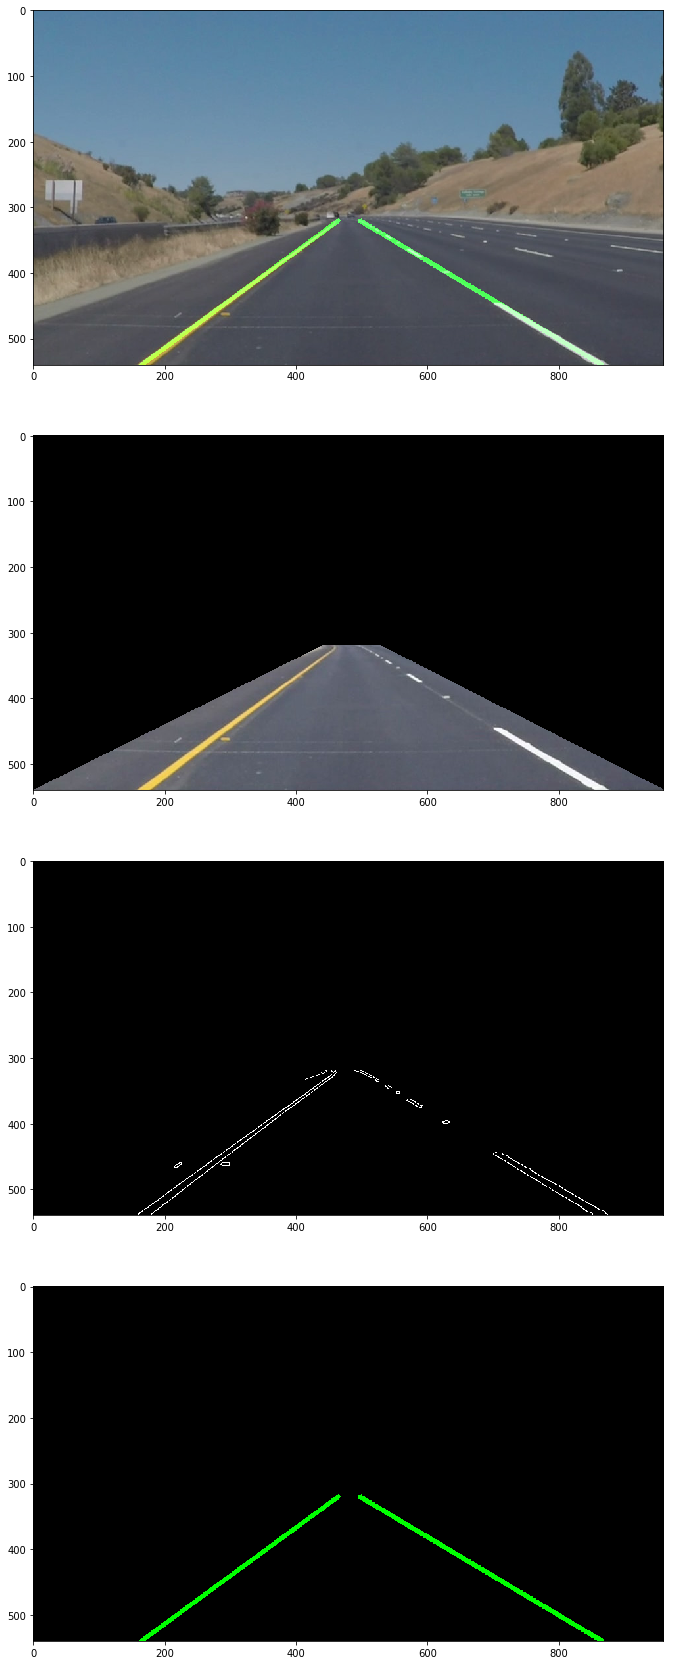

In [7]:
# List of all test images
imagelist = ['solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve2.jpg', 'solidYellowCurve.jpg', 'solidYellowLeft.jpg' , 'whiteCarLaneSwitch.jpg']
images = [mpimg.imread('test_images/' + img_name) for img_name in imagelist]

# Select image to process by changing index below
image = images[2]

# Run pipeline on the image below and display images
pipeline(image,display=True);

In [10]:
# List of all video filenames
filenames = ['solidWhiteRight.mp4', 'solidYellowLeft.mp4', 'challenge.mp4']
# Select filename to process by changing the index below
filename = filenames[2]

# Process the file selected above using our pipeline
process_image = lambda x: pipeline(x)
white_output = 'test_videos_output/' + filename
clip1 = VideoFileClip("test_videos/" + filename)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:13<00:00, 19.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

